# Random Forest


## Setup

Import necessary libraries and configure the environment for the data cleaning and preprocessing tasks.


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import OneHotEncoder

## Data Loading

Load the NBA shots data from CSV files for the years 2019 to 2023 and combine them into a single DataFrame.

In [111]:
years = [2015, 2019, 2020, 2021, 2022, 2023]
dfs = {'combined': pd.DataFrame()}  # Initialize a combined DataFrame

for year in years:
    file_path = f"NBA_{year}_Shots.csv"
    try:
        df = pd.read_csv(file_path)
        dfs[year] = df  # Store the DataFrame in the dictionary
        dfs['combined'] = pd.concat([dfs['combined'], df], ignore_index=True)  # Update the combined DataFrame
    except FileNotFoundError:
        print(f"The file 'NBA_{year}_Shots.csv' for {year} does not exist.")


# To select a specific year (e.g., 2020), you can access it like this:
df2015 = dfs[2015]
df2019 = dfs[2019]
df2020 = dfs[2020]
df2021 = dfs[2021]
df2022 = dfs[2022]
df2023 = dfs[2023]

# To select the combined data, you can access it like this:
dfcombined = dfs['combined']

## Data Cleaning

Identify and handle missing values in the dataset to ensure data quality for analysis.


In [112]:
# Check for missing values in each column
missing_values = dfcombined.isnull().sum()

# Print columns with missing values and their respective counts
print(missing_values[missing_values > 0])

POSITION_GROUP    5419
POSITION          5419
dtype: int64


In [113]:
# Handling missing values: Check the percentage of missing values in 'POSITION_GROUP' and 'POSITION'
missing_values_percentage = dfcombined[['POSITION_GROUP', 'POSITION']].isnull().mean() * 100

# Handling duplicate rows: Check for any duplicate rows in the data
duplicate_rows = dfcombined.duplicated().sum()

# Output the percentage of missing values and the number of duplicate rows
(missing_values_percentage, duplicate_rows)

(POSITION_GROUP    0.437705
 POSITION          0.437705
 dtype: float64,
 60)

In [114]:
# Detect outliers using Z-score

# Outlier detection for 'LOC_X'
z_scores_loc_x = np.abs(stats.zscore(dfcombined['LOC_X']))
outliers_loc_x = np.where(z_scores_loc_x > 3)
print(f"There are {len(outliers_loc_x[0])} outliers in the 'LOC_X' column.")

# Outlier detection for 'LOC_Y'
z_scores_loc_y = np.abs(stats.zscore(dfcombined['LOC_Y']))
outliers_loc_y = np.where(z_scores_loc_y > 3)
print(f"There are {len(outliers_loc_y[0])} outliers in the 'LOC_Y' column.")

# Outlier detection for 'SHOT_DISTANCE'
z_scores_shot_distance = np.abs(stats.zscore(dfcombined['SHOT_DISTANCE']))
outliers_shot_distance = np.where(z_scores_shot_distance > 3)
print(f"There are {len(outliers_shot_distance[0])} outliers in the 'SHOT_DISTANCE' column.")

There are 2842 outliers in the 'LOC_X' column.
There are 4186 outliers in the 'LOC_Y' column.
There are 2278 outliers in the 'SHOT_DISTANCE' column.


C:\Users\lweil\.conda\envs\FNN\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


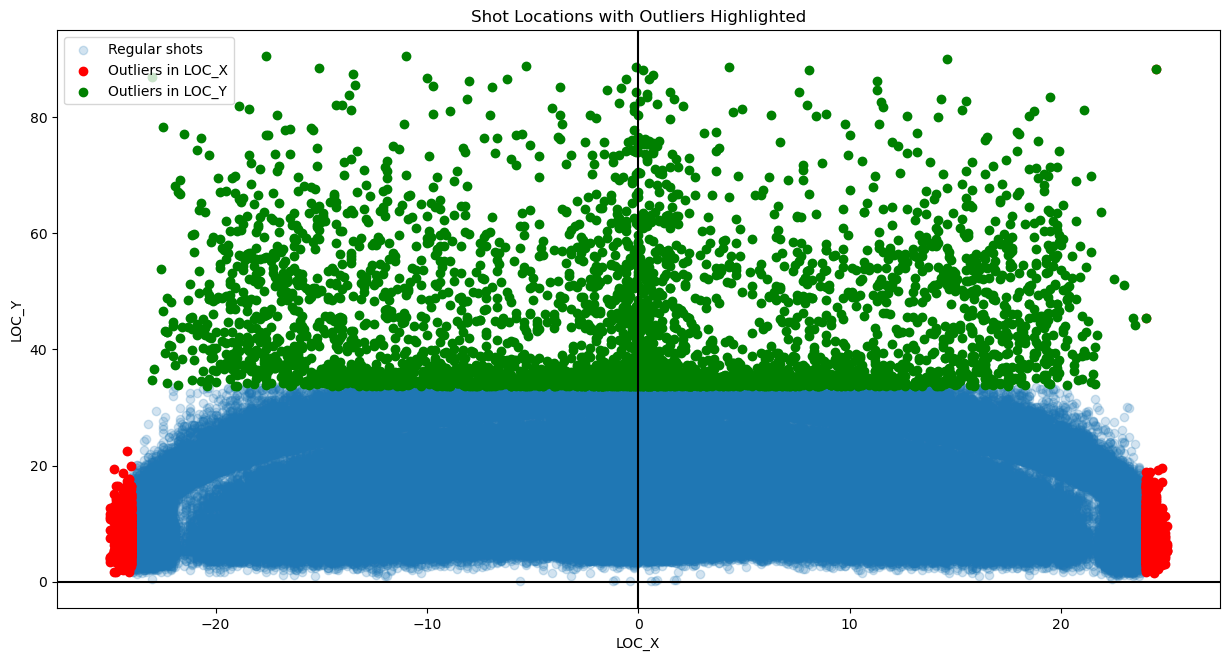

In [115]:
# Plotting LOC_X and LOC_Y to visualize shot locations
plt.figure(figsize=(15, 7.5))
# Plot a scatter plot of LOC_X and LOC_Y where the shots are made
plt.scatter(dfcombined['LOC_X'], dfcombined['LOC_Y'], alpha=0.2, label='Regular shots')
# Highlight the outliers
plt.scatter(dfcombined.loc[outliers_loc_x]['LOC_X'], dfcombined.loc[outliers_loc_x]['LOC_Y'], color='red', label='Outliers in LOC_X')
plt.scatter(dfcombined.loc[outliers_loc_y]['LOC_X'], dfcombined.loc[outliers_loc_y]['LOC_Y'], color='green', label='Outliers in LOC_Y')
plt.axhline(y=0, color='k')  # Add a line for the basket
plt.axvline(x=0, color='k')  # Center court line
plt.xlabel('LOC_X')
plt.ylabel('LOC_Y')
plt.title('Shot Locations with Outliers Highlighted')
plt.legend()
plt.show()

In [116]:
# Identify unique player names associated with each player ID
player_id_name = dfcombined.groupby('PLAYER_ID')['PLAYER_NAME'].unique()

# Identify player IDs with more than one associated name
inconsistent_players = player_id_name[player_id_name.apply(len) > 1]
print("Inconsistent Player IDs and names:")
print(inconsistent_players)

# Identify unique team names associated with each team ID
team_id_name = dfcombined.groupby('TEAM_ID')['TEAM_NAME'].unique()

# Identify team IDs with more than one associated name
inconsistent_teams = team_id_name[team_id_name.apply(len) > 1]
print("\nInconsistent Team IDs and names:")
print(inconsistent_teams)

Inconsistent Player IDs and names:
PLAYER_ID
1628384                   [O.G. Anunoby, OG Anunoby]
1628408                     [P.J. Dozier, PJ Dozier]
1630197    [Alekesej Pokusevski, Aleksej Pokusevski]
1630214         [Xavier Tillman Sr., Xavier Tillman]
1630288               [Jeff Dowtin, Jeff Dowtin Jr.]
1630527         [Brandon Boston, Brandon Boston Jr.]
Name: PLAYER_NAME, dtype: object

Inconsistent Team IDs and names:
TEAM_ID
1610612746    [Los Angeles Clippers, LA Clippers]
Name: TEAM_NAME, dtype: object


#### Analysis and Handling of Data Quality Issues
In the process of ensuring data quality for our NBA shots dataset, we have identified and addressed the following issues:

- Missing Values: The POSITION_GROUP and POSITION columns contain missing values, accounting for about 0.51% of the data. Due to the minimal impact, these rows have been removed.
- Duplicates: There are 60 instances of duplicate records. To maintain the dataset's integrity, these duplicates have been eliminated.
- Outliers: The LOC_X, LOC_Y, and SHOT_DISTANCE columns contain outliers. However, these values fall within the expected range of a basketball court and represent valid shot attempts, including less common long-range shots. Therefore, these outliers have been retained as they are crucial for a realistic representation of shot distribution.
- Inconsistent Player Names: The PLAYER ID and TEAM_ID columns had different ways of representing the same name

In [117]:
# Drop the duplicate rows
dfcombined_cleaned = dfcombined.drop_duplicates()

# Since the percentage of missing values is small, we will drop the rows with missing 'POSITION_GROUP' and 'POSITION'
dfcombined_cleaned = dfcombined_cleaned.dropna(subset=['POSITION_GROUP', 'POSITION'])

# Corrections for player names
player_name_corrections = {
    1630197: "Aleksej Pokusevski",
    1630527: "Brandon Boston Jr.",
    1628408: "PJ Dozier",
    1628384: "OG Anunoby",
    1630214: "Xavier Tillman Sr.",
    1630288: "Jeff Dowtin Jr."
}

# Apply the corrections for player names
dfcombined_cleaned['PLAYER_NAME'] = dfcombined_cleaned.apply(lambda row: player_name_corrections[row['PLAYER_ID']] if row['PLAYER_ID'] in player_name_corrections else row['PLAYER_NAME'], axis=1)

# Corrections for team names
team_name_corrections = {
    "LA Clippers": "Los Angeles Clippers"
}

# Apply the corrections for team names
dfcombined_cleaned['TEAM_NAME'] = dfcombined_cleaned['TEAM_NAME'].replace(team_name_corrections)

# Verify player name corrections
print("Corrected Player IDs and names:")
print(df.groupby('PLAYER_ID')['PLAYER_NAME'].unique())

# Verify team name corrections
print("\nCorrected Team IDs and names:")
print(df.groupby('TEAM_ID')['TEAM_NAME'].unique())

# Check if the cleaning was successful
cleaning_check = {
    "Remaining duplicates": dfcombined_cleaned.duplicated().sum(),
    "Remaining missing values": dfcombined_cleaned[['POSITION_GROUP', 'POSITION']].isnull().sum()
}

cleaning_check

Corrected Player IDs and names:
PLAYER_ID
2544             [LeBron James]
2617            [Udonis Haslem]
2738           [Andre Iguodala]
101108             [Chris Paul]
200752               [Rudy Gay]
                   ...         
1631323     [Simone Fontecchio]
1631367         [Jacob Gilyard]
1631466    [Jeenathan Williams]
1631495      [Donovan Williams]
1641645          [Xavier Cooks]
Name: PLAYER_NAME, Length: 537, dtype: object

Corrected Team IDs and names:
TEAM_ID
1610612737             [Atlanta Hawks]
1610612738            [Boston Celtics]
1610612739       [Cleveland Cavaliers]
1610612740      [New Orleans Pelicans]
1610612741             [Chicago Bulls]
1610612742          [Dallas Mavericks]
1610612743            [Denver Nuggets]
1610612744     [Golden State Warriors]
1610612745           [Houston Rockets]
1610612746               [LA Clippers]
1610612747        [Los Angeles Lakers]
1610612748                [Miami Heat]
1610612749           [Milwaukee Bucks]
1610612750    

{'Remaining duplicates': 0,
 'Remaining missing values': POSITION_GROUP    0
 POSITION          0
 dtype: int64}

## Data Preprocessing

##### Feature Description

Before transforming our features to be suitable for machine learning algorithms, let's summarize the characteristics of our numeric and categorical variables post-cleaning:

###### **Numeric Variables**
- There are 1,027,134 entries after cleaning.
- The SEASON_1 column, which seems to represent the year, ranges from 2019 to 2023.
- The SHOT_DISTANCE ranges from 0 to 88 feet, with a mean of approximately 13.5 feet.
- LOC_X and LOC_Y seem to represent the coordinates of the shot, with means close to 0, indicating that shots are spread around the basket.
- QUARTER ranges from 1 to 8, which may include overtime quarters.
- MINS_LEFT and SECS_LEFT show the time left in the quarter when the shot was taken.
###### **Categorical Variables**
- The dataset spans 5 seasons (SEASON_2), with '2018-19' being the most frequent season represented.
- TEAM_NAME and PLAYER_NAME have 31 and 948 unique entries, respectively, indicating the teams and players involved in the shots.
- Most shots were taken by guards (POSITION_GROUP) and specifically shooting guards (POSITION).
- The most common EVENT_TYPE is 'Missed Shot', which corresponds with the SHOT_MADE boolean column where False (missed shot) is more common than True (made shot).
- ACTION_TYPE has 48 unique types with 'Jump Shot' being the most common.
- The SHOT_TYPE indicates whether it was a 2-point or 3-point field goal.
- The BASIC_ZONE, ZONE_NAME, and ZONE_ABB columns describe the court area from which the shot was taken, with 'Restricted Area' and 'Center' being the most common zones.
- The ZONE_RANGE describes the distance category of the shot, with 'Less Than 8 ft.' being the most frequent.

#### Feature Transformation & Engineering

In this section, we map the categorical identifiers such as team IDs, player IDs, and zone abbreviations to their respective names for better interpretability. Additionally, we create a binary `IS_HOME_TEAM` column to indicate whether the team is playing at home, which simplifies the feature and reduces memory usage for future processing. This step is crucial for preparing the dataset for machine learning models, as it converts textual categorical data into a numerical format that can be easily processed by algorithms.

In [118]:
# Mapping Players & Teams with their IDs and zone names with its abbreviaton 

# Extract unique team IDs
unique_team_ids = dfcombined_cleaned['TEAM_ID'].unique()

# Extract unique team names
unique_team_names = dfcombined_cleaned['TEAM_NAME'].unique()

# Extract unique team abbreviations from the 'HOME_TEAM' column
unique_home_teams = dfcombined_cleaned['HOME_TEAM'].unique()

# Extract unique player IDs
unique_player_ids = dfcombined_cleaned['PLAYER_ID'].unique()

# Extract unique player names
unique_player_names = dfcombined_cleaned['PLAYER_NAME'].unique()

# Extract unique zone names
unique_zone_names = dfcombined_cleaned['ZONE_NAME'].unique()

# Extract unique zone abbreviations
unique_zone_abb = dfcombined_cleaned['ZONE_ABB'].unique()

In [119]:
# Creating a Is_Home_Team binary column in order to not double count the home/away feature and making it a numerical to save 
# memory + easier for future usage

# Mapping dictionaries to convert team, player identifiers and zone names to names and abbreviations.
team_id_to_name_mapping = dict(zip(unique_team_ids, unique_team_names))
team_abbreviation_to_id_mapping = dict(zip(unique_home_teams, unique_team_ids))
player_id_to_name_mapping = dict(zip(unique_player_ids, unique_player_names))
zone_abb_to_zonename_mapping = dict(zip(unique_zone_abb, unique_zone_names))

# Mapping team abbreviations to numeric team IDs for the 'HOME_TEAM' column.
team_abbr_to_id = {
    'LAC': 1610612762, 'ATL': 1610612746, 'MIL': 1610612737,
    'BKN': 1610612754, 'SAS': 1610612760, 'MEM': 1610612749,
    'NYK': 1610612751, 'PHI': 1610612748, 'DEN': 1610612742,
    'CHA': 1610612759, 'POR': 1610612744, 'DAL': 1610612752,
    'UTA': 1610612763, 'MIA': 1610612765, 'OKC': 1610612741,
    'LAL': 1610612750, 'DET': 1610612755, 'WAS': 1610612743,
    'MIN': 1610612766, 'NOP': 1610612753, 'CHI': 1610612758,
    'CLE': 1610612757, 'GSW': 1610612756, 'TOR': 1610612745,
    'SAC': 1610612747, 'BOS': 1610612764, 'HOU': 1610612738,
    'IND': 1610612761, 'ORL': 1610612740, 'PHX': 1610612739
}

# Apply the mapping to the 'HOME_TEAM' column to create a 'Home_Team_ID' column.
dfcombined_cleaned['Home_Team_ID'] = dfcombined_cleaned['HOME_TEAM'].map(team_abbr_to_id)

# Determine if the team is playing at home and encode this in a new 'Is_Home_Team' column.
dfcombined_cleaned['IS_HOME_TEAM'] = (dfcombined_cleaned['Home_Team_ID'] == dfcombined_cleaned['TEAM_ID']).astype(int)

# The DataFrame dfcombined_cleaned now has a binary 'Is_Home_Team' column indicating home (1) and away (0) games.
dfcombined_cleaned

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,Home_Team_ID,IS_HOME_TEAM
0,2015,2014-15,1610612743,Denver Nuggets,203115,Will Barton,G,SG,04-15-2015,21401229,...,C,Less Than 8 ft.,-0.4,6.75,1,4,0,18,1610612756,0
1,2015,2014-15,1610612744,Golden State Warriors,203949,James Michael McAdoo,F,PF,04-15-2015,21401229,...,C,Less Than 8 ft.,-0.0,5.35,0,4,0,22,1610612756,0
2,2015,2014-15,1610612739,Cleveland Cavaliers,1890,Shawn Marion,F,SF,04-15-2015,21401225,...,C,Less Than 8 ft.,-0.0,5.35,0,5,0,3,1610612757,0
3,2015,2014-15,1610612744,Golden State Warriors,203949,James Michael McAdoo,F,PF,04-15-2015,21401229,...,C,Less Than 8 ft.,-0.0,5.35,0,4,0,37,1610612756,0
4,2015,2014-15,1610612743,Denver Nuggets,203475,Erick Green,G,PG,04-15-2015,21401229,...,L,16-24 ft.,16.9,14.85,19,4,0,48,1610612756,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1238044,2023,2022-23,1610612737,Atlanta Hawks,1631495,Donovan Williams,G,SG,04-09-2023,22201216,...,C,Less Than 8 ft.,-2.1,7.45,3,4,1,37,1610612764,0
1238045,2023,2022-23,1610612737,Atlanta Hawks,1631495,Donovan Williams,G,SG,04-09-2023,22201216,...,RC,24+ ft.,-14.5,26.45,25,4,1,12,1610612764,0
1238046,2023,2022-23,1610612737,Atlanta Hawks,1628981,Bruno Fernando,C,C,04-09-2023,22201216,...,C,Less Than 8 ft.,2.0,7.55,3,4,1,2,1610612764,0
1238047,2023,2022-23,1610612737,Atlanta Hawks,1628981,Bruno Fernando,C,C,04-09-2023,22201216,...,C,24+ ft.,0.2,30.85,25,4,0,28,1610612764,0


#### Date Feature Engineering
The GAME_DATE column is converted to a datetime object to extract additional features that may be relevant for analysis, such as the day of the week and month of the game. The year is already given in SEASON_1 column.

In [120]:
# Converting 'GAME_DATE' column to a datetime object and extracting relevant features (year not needed = SEASON_1)
dfcombined_cleaned['GAME_DATE'] = pd.to_datetime(dfcombined_cleaned['GAME_DATE'])

# Extracting the month as a number (1-12)
dfcombined_cleaned['MONTH'] = dfcombined_cleaned['GAME_DATE'].dt.month

# Extracting the day of the month as a number (1-31)
dfcombined_cleaned['DAY'] = dfcombined_cleaned['GAME_DATE'].dt.day

# Extracting the day of the week as a number (1-7, where Monday=1, Sunday=7)
dfcombined_cleaned['WEEKDAY'] = dfcombined_cleaned['GAME_DATE'].dt.dayofweek + 1

dfcombined_cleaned

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,Home_Team_ID,IS_HOME_TEAM,MONTH,DAY,WEEKDAY
0,2015,2014-15,1610612743,Denver Nuggets,203115,Will Barton,G,SG,2015-04-15,21401229,...,6.75,1,4,0,18,1610612756,0,4,15,3
1,2015,2014-15,1610612744,Golden State Warriors,203949,James Michael McAdoo,F,PF,2015-04-15,21401229,...,5.35,0,4,0,22,1610612756,0,4,15,3
2,2015,2014-15,1610612739,Cleveland Cavaliers,1890,Shawn Marion,F,SF,2015-04-15,21401225,...,5.35,0,5,0,3,1610612757,0,4,15,3
3,2015,2014-15,1610612744,Golden State Warriors,203949,James Michael McAdoo,F,PF,2015-04-15,21401229,...,5.35,0,4,0,37,1610612756,0,4,15,3
4,2015,2014-15,1610612743,Denver Nuggets,203475,Erick Green,G,PG,2015-04-15,21401229,...,14.85,19,4,0,48,1610612756,0,4,15,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1238044,2023,2022-23,1610612737,Atlanta Hawks,1631495,Donovan Williams,G,SG,2023-04-09,22201216,...,7.45,3,4,1,37,1610612764,0,4,9,7
1238045,2023,2022-23,1610612737,Atlanta Hawks,1631495,Donovan Williams,G,SG,2023-04-09,22201216,...,26.45,25,4,1,12,1610612764,0,4,9,7
1238046,2023,2022-23,1610612737,Atlanta Hawks,1628981,Bruno Fernando,C,C,2023-04-09,22201216,...,7.55,3,4,1,2,1610612764,0,4,9,7
1238047,2023,2022-23,1610612737,Atlanta Hawks,1628981,Bruno Fernando,C,C,2023-04-09,22201216,...,30.85,25,4,0,28,1610612764,0,4,9,7


#### Creation of TIME_LEFT Column

The `TIME_LEFT` column is computed by converting the minutes left (`MINS_LEFT`) to seconds and adding the remaining seconds (`SECS_LEFT`). This transformation facilitates the analysis of time-related patterns in the data by representing the time left in the game as a single numeric value in seconds.


In [121]:
# Convert 'MINS_LEFT' to seconds and add 'SECS_LEFT' to create 'TOTAL_TIME_LEFT' in seconds (including overtime)

dfcombined_cleaned['TOTAL_TIME_LEFT'] = dfcombined_cleaned.apply(
    lambda row: (((4 - row['QUARTER']) * 12 * 60) + (row['MINS_LEFT'] * 60) + row['SECS_LEFT']) 
    if row['QUARTER'] <= 4 
    else ((row['MINS_LEFT'] * 60) + row['SECS_LEFT']), axis=1)

# Re-display the first few rows to check the changes
dfcombined_cleaned[['QUARTER', 'MINS_LEFT', 'SECS_LEFT', 'TOTAL_TIME_LEFT']].head(15)

#### Normalization of LOC_X and LOC_Y
LOC_X and LOC_Y show different scalings throughout the year. This makes it hard to compare the different years, which is why in the following the values are being normalized to scale LOC_X and LOC_Y to the scale of a basketball court.

In [122]:
# Normalization function to scale LOC_X and LOC_Y values
def normalize_coordinates(dataframe, new_x_range=(-25, 25), new_y_range=(0, 94)):
    """
    This function normalizes LOC_X and LOC_Y values to a given range.
    The new_x_range and new_y_range parameters define the desired output range for LOC_X and LOC_Y.
    """
    x_min, x_max = new_x_range
    y_min, y_max = new_y_range
    
    # Normalize LOC_X
    x_range = dataframe['LOC_X'].max() - dataframe['LOC_X'].min()
    dataframe['NORM_LOC_X'] = ((dataframe['LOC_X'] - dataframe['LOC_X'].min()) / x_range) * (x_max - x_min) + x_min
    
    # Normalize LOC_Y
    y_range = dataframe['LOC_Y'].max() - dataframe['LOC_Y'].min()
    dataframe['NORM_LOC_Y'] = ((dataframe['LOC_Y'] - dataframe['LOC_Y'].min()) / y_range) * (y_max - y_min) + y_min
    
    return dataframe

# Now we will group by 'SEASON_1' and normalize within each season
df_list = []
for season, group in dfcombined_cleaned.groupby('SEASON_1'):
    normalized_group = normalize_coordinates(group)
    df_list.append(normalized_group)

# Concatenate all the normalized groups back into a single dataframe
dfcombined_cleaned = pd.concat(df_list)

# Verify normalization by checking the range of values for the first season
dfcombined_cleaned[dfcombined_cleaned['SEASON_1'] == 2019][['NORM_LOC_X', 'NORM_LOC_Y']].agg(['min', 'max'])

,NORM_LOC_X,NORM_LOC_Y
min,-25.0,0.0
max,25.0,94.0


### Feature Reduction and Type Conversion

##### Reducing Redundant Features
To streamline the dataset, redundant or unnecessary features are removed. This includes dropping columns that are represented by other, more effective identifiers or that have been encoded into new features.

##### Columns Dropped
- `PLAYER_NAME` and `TEAM_NAME` are removed in favor of `PLAYER_ID` and `TEAM_ID`.
- `SEASON_2` is redundant due to `SEASON_1`, which will also be renamed to `SEASON` .
- `ZONE_NAME` is represented by `ZONE_ABB`.
- `EVENT_TYPE` is captured by the binary `SHOT_MADE`.
- `Game_ID` is excluded because it is specific to past games and will not be applicable for future shot predictions. It merely indicates that shots were taken in the same game, which is not useful for our predictive modeling.
- `Home_Team_ID`, `HOME_TEAM`, and `AWAY_TEAM` are removed as they have been replaced by the binary `Is_Home_Team` column, which simplifies the dataset and avoids duplicative information.
- `MINS_LEFT` and `SECS_LEFT` are consolidated into `TIME_LEFT` in seconds, which makes the original columns unnecessary.
- `GAME_DATE` is already captured in `SEASON`, `Month` and `Day` 

In [123]:
# Drop unecessary columns

dfcombined_cleaned = dfcombined_cleaned.drop(['PLAYER_NAME', 'TEAM_NAME', 'SEASON_2', 'ZONE_NAME', 'EVENT_TYPE', 'GAME_ID', 'Home_Team_ID','HOME_TEAM','AWAY_TEAM', 'MINS_LEFT', 'SECS_LEFT', 'GAME_DATE', 'LOC_X', 'LOC_Y'], axis=1)

# Rename 'SEASON_1' column to 'SEASON'
dfcombined_cleaned.rename(columns={'SEASON_1': 'SEASON'}, inplace=True)
dfcombined_cleaned

,SEASON,TEAM_ID,PLAYER_ID,POSITION_GROUP,POSITION,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,BASIC_ZONE,ZONE_ABB,ZONE_RANGE,SHOT_DISTANCE,QUARTER,IS_HOME_TEAM,MONTH,DAY,WEEKDAY,TIME_LEFT,NORM_LOC_X,NORM_LOC_Y
0,2015,1610612743,203115,G,SG,True,Driving Layup Shot,2PT Field Goal,Restricted Area,C,Less Than 8 ft.,1,4,0,4,15,3,18,-0.400000,6.870432
1,2015,1610612744,203949,F,PF,True,Slam Dunk Shot,2PT Field Goal,Restricted Area,C,Less Than 8 ft.,0,4,0,4,15,3,22,0.000000,5.413068
2,2015,1610612739,1890,F,SF,True,Slam Dunk Shot,2PT Field Goal,Restricted Area,C,Less Than 8 ft.,0,5,0,4,15,3,3,0.000000,5.413068
3,2015,1610612744,203949,F,PF,True,Slam Dunk Shot,2PT Field Goal,Restricted Area,C,Less Than 8 ft.,0,4,0,4,15,3,37,0.000000,5.413068
4,2015,1610612743,203475,G,PG,False,Pullup Jump shot,2PT Field Goal,Mid-Range,L,16-24 ft.,19,4,0,4,15,3,48,16.900000,15.302326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1238044,2023,1610612737,1631495,G,SG,True,Running Layup Shot,2PT Field Goal,Restricted Area,C,Less Than 8 ft.,3,4,0,4,9,7,97,-2.054108,7.977064
1238045,2023,1610612737,1631495,G,SG,False,Pullup Jump shot,3PT Field Goal,Above the Break 3,RC,24+ ft.,25,4,0,4,9,7,72,-14.478958,28.458716
1238046,2023,1610612737,1628981,C,C,True,Alley Oop Layup shot,2PT Field Goal,Restricted Area,C,Less Than 8 ft.,3,4,0,4,9,7,62,2.054108,8.084862
1238047,2023,1610612737,1628981,C,C,False,Jump Shot,3PT Field Goal,Above the Break 3,C,24+ ft.,25,4,0,4,9,7,28,0.250501,33.201835


#### Type Conversion
Categorical columns are explicitly converted to categorical types to optimize memory usage and improve the performance of machine learning models.

In [124]:
# Convert SHOT_MADE to binary
dfcombined_cleaned['SHOT_MADE'] = dfcombined_cleaned['SHOT_MADE'].astype(int)

# Map SHOT_TYPE to binary
shot_type_mapping = {'2PT Field Goal': 0, '3PT Field Goal': 1}
dfcombined_cleaned['SHOT_TYPE'] = dfcombined_cleaned['SHOT_TYPE'].map(shot_type_mapping)

# Convert SEASON and QUARTER to ordinal
season_order = sorted(dfcombined_cleaned['SEASON'].unique())
quarter_order = sorted(dfcombined_cleaned['QUARTER'].unique())
dfcombined_cleaned['SEASON'] = pd.Categorical(dfcombined_cleaned['SEASON'], categories=season_order, ordered=True)
dfcombined_cleaned['QUARTER'] = pd.Categorical(dfcombined_cleaned['QUARTER'], categories=quarter_order, ordered=True)

# Convert MONTH and WEEKDAY to categorical
dfcombined_cleaned['MONTH'] = dfcombined_cleaned['MONTH'].astype('category')
dfcombined_cleaned['WEEKDAY'] = dfcombined_cleaned['WEEKDAY'].astype('category')

# Leave DAY as numerical unless there's a need to treat it as categorical

# Convert ACTION_TYPE, BASIC_ZONE, ZONE_ABB, and ZONE_RANGE to categorical
categorical_columns = ['PLAYER_ID', 'TEAM_ID', 'ACTION_TYPE', 'BASIC_ZONE', 'ZONE_ABB', 'ZONE_RANGE', 'POSITION_GROUP', 'POSITION']
for col in categorical_columns:
    dfcombined_cleaned[col] = dfcombined_cleaned[col].astype('category')
 
dfcombined_cleaned

,SEASON,TEAM_ID,PLAYER_ID,POSITION_GROUP,POSITION,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,BASIC_ZONE,ZONE_ABB,ZONE_RANGE,SHOT_DISTANCE,QUARTER,IS_HOME_TEAM,MONTH,DAY,WEEKDAY,TIME_LEFT,NORM_LOC_X,NORM_LOC_Y
0,2015,1610612743,203115,G,SG,1,Driving Layup Shot,0,Restricted Area,C,Less Than 8 ft.,1,4,0,4,15,3,18,-0.400000,6.870432
1,2015,1610612744,203949,F,PF,1,Slam Dunk Shot,0,Restricted Area,C,Less Than 8 ft.,0,4,0,4,15,3,22,0.000000,5.413068
2,2015,1610612739,1890,F,SF,1,Slam Dunk Shot,0,Restricted Area,C,Less Than 8 ft.,0,5,0,4,15,3,3,0.000000,5.413068
3,2015,1610612744,203949,F,PF,1,Slam Dunk Shot,0,Restricted Area,C,Less Than 8 ft.,0,4,0,4,15,3,37,0.000000,5.413068
4,2015,1610612743,203475,G,PG,0,Pullup Jump shot,0,Mid-Range,L,16-24 ft.,19,4,0,4,15,3,48,16.900000,15.302326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1238044,2023,1610612737,1631495,G,SG,1,Running Layup Shot,0,Restricted Area,C,Less Than 8 ft.,3,4,0,4,9,7,97,-2.054108,7.977064
1238045,2023,1610612737,1631495,G,SG,0,Pullup Jump shot,1,Above the Break 3,RC,24+ ft.,25,4,0,4,9,7,72,-14.478958,28.458716
1238046,2023,1610612737,1628981,C,C,1,Alley Oop Layup shot,0,Restricted Area,C,Less Than 8 ft.,3,4,0,4,9,7,62,2.054108,8.084862
1238047,2023,1610612737,1628981,C,C,0,Jump Shot,1,Above the Break 3,C,24+ ft.,25,4,0,4,9,7,28,0.250501,33.201835


#### Memory Optimization for Numerical Variables

##### Reducing Data Type Sizes
To enhance computational efficiency and reduce memory usage, numerical columns are cast to more memory-efficient data types. Float64 columns are converted to float32, and int64 columns are converted to int32.

In [125]:
# Convert binary columns to int32
dfcombined_cleaned['SHOT_MADE'] = dfcombined_cleaned['SHOT_MADE'].astype('int32')
dfcombined_cleaned['IS_HOME_TEAM'] = dfcombined_cleaned['IS_HOME_TEAM'].astype('int32')

# Convert other integer columns to int32
dfcombined_cleaned['DAY'] = dfcombined_cleaned['DAY'].astype('int32')
dfcombined_cleaned['TOTAL_TIME_LEFT'] = dfcombined_cleaned['TIME_LEFT'].astype('int32')
dfcombined_cleaned['SHOT_DISTANCE'] = dfcombined_cleaned['SHOT_DISTANCE'].astype('int32')

#### Data Integrity Check

##### Verifying Data Types and Cardinality
After preprocessing, it is crucial to verify that data types are correctly assigned and to understand the cardinality of categorical variables. This step ensures that the dataset is ready for encoding and further analysis.

In [126]:
#checking for Types and amount of unique values

dfcombined_cleaned.info()

# Define the categorical columns to be encoded
categorical_columns = [
    'TEAM_ID', 'PLAYER_ID', 'POSITION_GROUP', 'POSITION',
    'ACTION_TYPE', 'BASIC_ZONE', 'ZONE_ABB', 'ZONE_RANGE', 'MONTH', 'WEEKDAY'
]

for col in categorical_columns:
    print(f"{col}: {dfcombined_cleaned[col].nunique()} unique values")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1232570 entries, 0 to 1238048
Data columns (total 20 columns):
 #   Column          Non-Null Count    Dtype   
---  ------          --------------    -----   
 0   SEASON          1232570 non-null  category
 1   TEAM_ID         1232570 non-null  category
 2   PLAYER_ID       1232570 non-null  category
 3   POSITION_GROUP  1232570 non-null  category
 4   POSITION        1232570 non-null  category
 5   SHOT_MADE       1232570 non-null  int32   
 6   ACTION_TYPE     1232570 non-null  category
 7   SHOT_TYPE       1232570 non-null  int64   
 8   BASIC_ZONE      1232570 non-null  category
 9   ZONE_ABB        1232570 non-null  category
 10  ZONE_RANGE      1232570 non-null  category
 11  SHOT_DISTANCE   1232570 non-null  int32   
 12  QUARTER         1232570 non-null  category
 13  IS_HOME_TEAM    1232570 non-null  int32   
 14  MONTH           1232570 non-null  category
 15  DAY             1232570 non-null  int32   
 16  WEEKDAY         12

### Encoding
#### Ordinal Encoding
To utilize categorical features in machine learning models, we need to encode these features numerically. This process involves converting categories to a numerical format that preserves any inherent order in the categories.

In [127]:
# Ensure SEASON is an ordered categorical type
dfcombined_cleaned['SEASON'] = dfcombined_cleaned['SEASON'].cat.as_ordered()

# Define the order for QUARTER, assuming 5, 6, 7, 8 are overtime periods
quarter_mapping = {1: 'Q1', 2: 'Q2', 3: 'Q3', 4: 'Q4', 5: 'OT1', 6: 'OT2', 7: 'OT3', 8: 'OT4'}

# Map the QUARTER column to the ordered categorical type
dfcombined_cleaned['QUARTER'] = dfcombined_cleaned['QUARTER'].map(quarter_mapping).astype('category')

# Set the categories and order for the QUARTER column
dfcombined_cleaned['QUARTER'] = dfcombined_cleaned['QUARTER'].cat.set_categories(
    ['Q1', 'Q2', 'Q3', 'Q4', 'OT1', 'OT2', 'OT3', 'OT4'], ordered=True
)

# Check the conversion
print(dfcombined_cleaned['QUARTER'].head())

0     Q4
1     Q4
2    OT1
3     Q4
4     Q4
Name: QUARTER, dtype: category
Categories (8, object): ['Q1' < 'Q2' < 'Q3' < 'Q4' < 'OT1' < 'OT2' < 'OT3' < 'OT4']


In [128]:
# Check if SEASON is ordered
print("SEASON ordered:", dfcombined_cleaned['SEASON'].cat.ordered)
print("SEASON categories:", dfcombined_cleaned['SEASON'].cat.categories)

# Check if QUARTER is ordered
print("QUARTER ordered:", dfcombined_cleaned['QUARTER'].cat.ordered)
print("QUARTER categories:", dfcombined_cleaned['QUARTER'].cat.categories)

SEASON ordered: True
SEASON categories: Int64Index([2015, 2019, 2020, 2021, 2022, 2023], dtype='int64')
QUARTER ordered: True
QUARTER categories: Index(['Q1', 'Q2', 'Q3', 'Q4', 'OT1', 'OT2', 'OT3', 'OT4'], dtype='object')


In [129]:
# For SEASON
season_categories = dfcombined_cleaned['SEASON'].cat.categories
season_mapping = {k: v for k, v in enumerate(season_categories)}
print("Season encoding mapping:", season_mapping)

# For QUARTER
quarter_categories = dfcombined_cleaned['QUARTER'].cat.categories
quarter_mapping = {k: v for k, v in enumerate(quarter_categories)}
print("Quarter encoding mapping:", quarter_mapping)

Season encoding mapping: {0: 2015, 1: 2019, 2: 2020, 3: 2021, 4: 2022, 5: 2023}
Quarter encoding mapping: {0: 'Q1', 1: 'Q2', 2: 'Q3', 3: 'Q4', 4: 'OT1', 5: 'OT2', 6: 'OT3', 7: 'OT4'}


In [130]:
# Convert 'SEASON' and 'QUARTER' to numeric codes
dfcombined_cleaned['SEASON'] = dfcombined_cleaned['SEASON'].cat.codes
dfcombined_cleaned['QUARTER'] = dfcombined_cleaned['QUARTER'].cat.codes

# Add 1 to each to start the numbering from 1
dfcombined_cleaned['SEASON'] += 1
dfcombined_cleaned['QUARTER'] += 1

# Verify the conversion by checking the data types again
print(dfcombined_cleaned[['SEASON', 'QUARTER']].dtypes)

SEASON     int8
QUARTER    int8
dtype: object


#### One-Hot Encoding of Categorical Variables

##### Preparing Categorical Variables for Machine Learning
To facilitate the use of categorical data in machine learning models, we apply one-hot encoding. This process converts categorical variables into a binary matrix representation, which is essential for models that require numerical input.

##### Encoding Process
- Initialize the `OneHotEncoder`.
- Fit the encoder to the categorical columns and transform them into a sparse matrix to optimize memory.
- Create a new DataFrame with encoded variables.

##### Integrating Encoded Features
- The original categorical columns are dropped from the cleaned DataFrame.
- The new encoded features are concatenated with the remaining data.
- A final check is performed to ensure no missing values are introduced during this process.


In [131]:
# Define the categorical columns to be encoded
categorical_columns = [
    'TEAM_ID', 'PLAYER_ID', 'POSITION_GROUP', 'POSITION',
    'ACTION_TYPE', 'BASIC_ZONE', 'ZONE_ABB', 'ZONE_RANGE', 'MONTH', 'WEEKDAY'
]

# Initialize the OneHotEncoder with sparse output
encoder = OneHotEncoder(sparse=True, dtype=np.float32)

# Fit and transform the categorical columns
encoded_data = encoder.fit_transform(dfcombined_cleaned[categorical_columns])

# Get feature names for the encoded columns
encoded_columns = encoder.get_feature_names_out(categorical_columns)

# Create a DataFrame with the encoded variables
encoded_df = pd.DataFrame.sparse.from_spmatrix(encoded_data, columns=encoded_columns)

# Reset the index of the original DataFrame if necessary
dfcombined_cleaned.reset_index(drop=True, inplace=True)

# Reset the index of the encoded DataFrame to match
encoded_df.reset_index(drop=True, inplace=True)

# Drop the original categorical columns from the cleaned DataFrame
dfcombined_cleaned = dfcombined_cleaned.drop(categorical_columns, axis=1)

# Concatenate the encoded DataFrame with the original one, excluding the dropped categorical columns
dfcombined_cleaned = pd.concat([dfcombined_cleaned, encoded_df], axis=1)

# Check the first few rows of the resulting DataFrame
display(dfcombined_cleaned.head())

# Verify that there are no missing values after concatenation
missing_values_after = dfcombined_cleaned.isnull().sum()
print("Missing values after concatenation:\n", missing_values_after)

,SEASON,SHOT_MADE,SHOT_TYPE,SHOT_DISTANCE,QUARTER,IS_HOME_TEAM,DAY,TIME_LEFT,NORM_LOC_X,NORM_LOC_Y,...,MONTH_10,MONTH_11,MONTH_12,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6,WEEKDAY_7
0,1,1,0,1,4,0,15,18,-0.4,6.870432,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,1,0,0,4,0,15,22,0.0,5.413068,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,1,0,0,5,0,15,3,0.0,5.413068,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,1,0,0,4,0,15,37,0.0,5.413068,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,0,0,19,4,0,15,48,16.9,15.302326,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Missing values after concatenation:
 SEASON           0
SHOT_MADE        0
SHOT_TYPE        0
SHOT_DISTANCE    0
QUARTER          0
                ..
WEEKDAY_3        0
WEEKDAY_4        0
WEEKDAY_5        0
WEEKDAY_6        0
WEEKDAY_7        0
Length: 1349, dtype: int64


### Output

After data cleaning, transformation, and optimization, the dataset is now fully preprocessed. We have addressed missing values, removed duplicates, transformed categorical variables into a machine-learning-friendly format using one-hot encoding, and optimized memory usage by adjusting data types. The dataset is now primed for the next phase of our analysis, which involves feature selection and model development. This structured and clean dataset forms a solid foundation for building robust predictive models and extracting meaningful insights

In [132]:
# Define your features and target
X = dfcombined_cleaned.drop(['SHOT_MADE'], axis=1) #features
y = dfcombined_cleaned['SHOT_MADE'] #target

display([y])
X

[0          1
 1          1
 2          1
 3          1
 4          0
           ..
 1232565    1
 1232566    0
 1232567    1
 1232568    0
 1232569    1
 Name: SHOT_MADE, Length: 1232570, dtype: int32]

,SEASON,SHOT_TYPE,SHOT_DISTANCE,QUARTER,IS_HOME_TEAM,DAY,TIME_LEFT,NORM_LOC_X,NORM_LOC_Y,TEAM_ID_1610612737,...,MONTH_10,MONTH_11,MONTH_12,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6,WEEKDAY_7
0,1,0,1,4,0,15,18,-0.400000,6.870432,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,0,0,4,0,15,22,0.000000,5.413068,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,0,0,5,0,15,3,0.000000,5.413068,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,0,0,4,0,15,37,0.000000,5.413068,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,0,19,4,0,15,48,16.900000,15.302326,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232565,6,0,3,4,0,9,97,-2.054108,7.977064,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1232566,6,1,25,4,0,9,72,-14.478958,28.458716,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1232567,6,0,3,4,0,9,62,2.054108,8.084862,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1232568,6,1,25,4,0,9,28,0.250501,33.201835,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [133]:
dfcombined_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232570 entries, 0 to 1232569
Columns: 1349 entries, SEASON to WEEKDAY_7
dtypes: Sparse[float32, 0](1339), float64(2), int32(5), int64(1), int8(2)
memory usage: 148.1 MB


In [134]:
# retrieving the dataframe for the year 2015
df2015 =  dfcombined_cleaned[dfcombined_cleaned.SEASON == 1]

In [135]:
df2015

,SEASON,SHOT_MADE,SHOT_TYPE,SHOT_DISTANCE,QUARTER,IS_HOME_TEAM,DAY,TIME_LEFT,NORM_LOC_X,NORM_LOC_Y,...,MONTH_10,MONTH_11,MONTH_12,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6,WEEKDAY_7
0,1,1,0,1,4,0,15,18,-0.4,6.870432,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,1,0,0,4,0,15,22,0.0,5.413068,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,1,0,0,5,0,15,3,0.0,5.413068,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,1,0,0,4,0,15,37,0.0,5.413068,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,0,0,19,4,0,15,48,16.9,15.302326,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205431,1,1,0,5,1,0,28,683,1.0,10.722038,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
205432,1,0,0,1,1,0,28,692,1.0,5.933555,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
205433,1,0,0,18,1,0,28,708,11.4,20.403101,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
205434,1,0,0,20,1,0,28,703,-5.0,25.503876,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [136]:
# Dropping rows where SEASON is equal to 2015
dfcombined_cleaned = dfcombined_cleaned[dfcombined_cleaned.SEASON != 1]

In [137]:
# Define your features and target
X = dfcombined_cleaned.drop(['SHOT_MADE'], axis=1) #features
y = dfcombined_cleaned['SHOT_MADE'] #target

display([y])
X

[205436     1
 205437     1
 205438     1
 205439     1
 205440     1
           ..
 1232565    1
 1232566    0
 1232567    1
 1232568    0
 1232569    1
 Name: SHOT_MADE, Length: 1027134, dtype: int32]

,SEASON,SHOT_TYPE,SHOT_DISTANCE,QUARTER,IS_HOME_TEAM,DAY,TIME_LEFT,NORM_LOC_X,NORM_LOC_Y,TEAM_ID_1610612737,...,MONTH_10,MONTH_11,MONTH_12,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6,WEEKDAY_7
205436,2,1,23,5,1,10,18,-22.188755,11.763128,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
205437,2,0,11,5,0,10,27,-2.208835,16.699441,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
205438,2,1,32,4,0,10,2,0.502008,38.125140,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
205439,2,0,2,5,1,10,46,-1.204819,6.406704,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
205440,2,1,24,5,0,10,55,-19.076305,20.795531,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232565,6,0,3,4,0,9,97,-2.054108,7.977064,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1232566,6,1,25,4,0,9,72,-14.478958,28.458716,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1232567,6,0,3,4,0,9,62,2.054108,8.084862,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1232568,6,1,25,4,0,9,28,0.250501,33.201835,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [138]:
# Save the entire DataFrame to a CSV file
#dfcombined_cleaned.to_csv('preprocessed_data.csv', index=False)

In [139]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Importance

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


# Create a RandomForest Classifier with a smaller number of trees
rf = RandomForestClassifier(n_estimators=50, random_state=42)  # Using 50 trees

# Fit the model
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort the feature importances in descending order

# Select the top 15 features
top_indices = indices[:15]


C:\Users\lweil\.conda\envs\FNN\lib\site-packages\sklearn\utils\validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


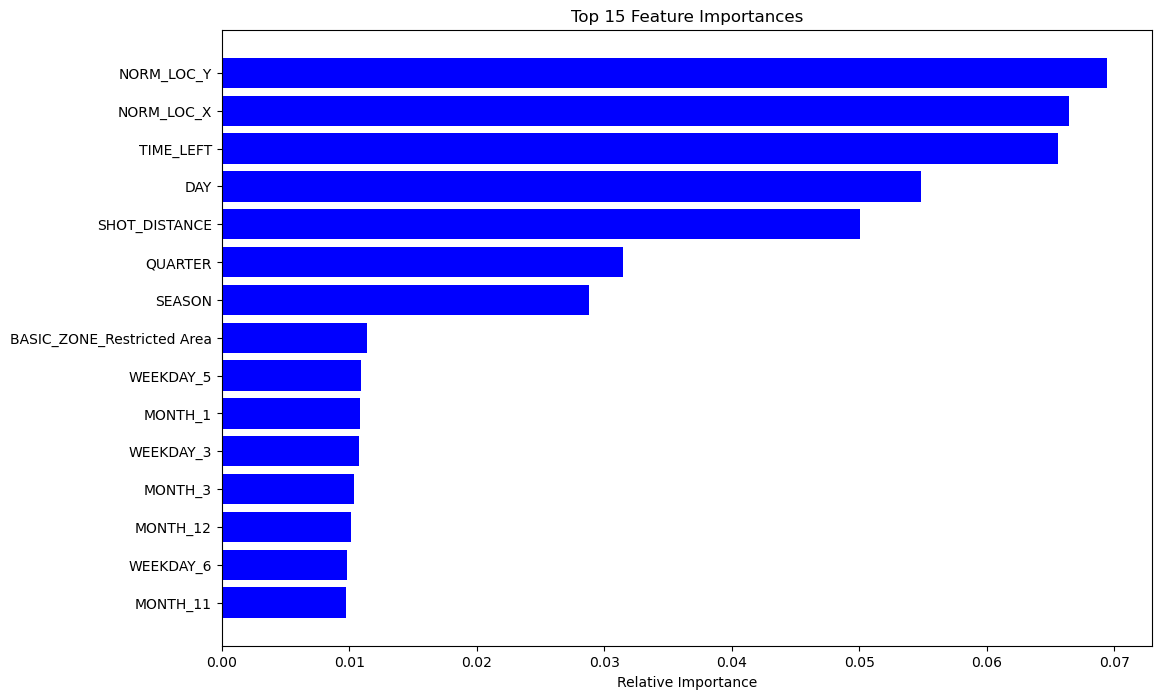

In [66]:
top_features = X.columns[top_indices]
top_importances = importances[top_indices]

# Plotting as a horizontal bar chart
plt.figure(figsize=(12, 8))
plt.title("Top 15 Feature Importances")
plt.barh(range(len(top_indices)), top_importances, align='center', color='blue')
plt.yticks(range(len(top_indices)), top_features, rotation=0)
plt.xlabel('Relative Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()

In [31]:
# Select a different number of top features based on feature importances
top_features = feature_importances.head(500).index  # Choose top 500 features

# Reduce X to the new top features
X_top = X[top_features]

# You only need to update X_train and X_test based on the new feature set
X_train_top, X_test_top = X_train[top_features], X_test[top_features]
X_top

,NORM_LOC_Y,TIME_LEFT,NORM_LOC_X,DAY,SHOT_DISTANCE,QUARTER,SEASON,WEEKDAY_3,MONTH_1,WEEKDAY_5,...,PLAYER_ID_202738,PLAYER_ID_1628410,PLAYER_ID_1629723,PLAYER_ID_1626161,PLAYER_ID_1627774,PLAYER_ID_1629002,PLAYER_ID_1629656,PLAYER_ID_1626188,PLAYER_ID_1630188,PLAYER_ID_1626172
0,11.763128,18,-22.188755,10,23,5,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,16.699441,27,-2.208835,10,11,5,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,38.125140,2,0.502008,10,32,4,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.406704,46,-1.204819,10,2,5,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20.795531,55,-19.076305,10,24,5,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027129,7.977064,97,-2.054108,9,3,4,5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1027130,28.458716,72,-14.478958,9,25,4,5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1027131,8.084862,62,2.054108,9,3,4,5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1027132,33.201835,28,0.250501,9,25,4,5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Tested with top 285 features, cross-validation accuracy: 0.6046
Tested with top 295 features, cross-validation accuracy: 0.6044
Tested with top 305 features, cross-validation accuracy: 0.6045
Tested with top 315 features, cross-validation accuracy: 0.6043
Tested with top 325 features, cross-validation accuracy: 0.6052
Tested with top 335 features, cross-validation accuracy: 0.6057
Tested with top 345 features, cross-validation accuracy: 0.6048
Tested with top 355 features, cross-validation accuracy: 0.6051
Tested with top 365 features, cross-validation accuracy: 0.6056
Tested with top 375 features, cross-validation accuracy: 0.6053
Tested with top 385 features, cross-validation accuracy: 0.6064
Tested with top 395 features, cross-validation accuracy: 0.6055
Tested with top 405 features, cross-validation accuracy: 0.6043


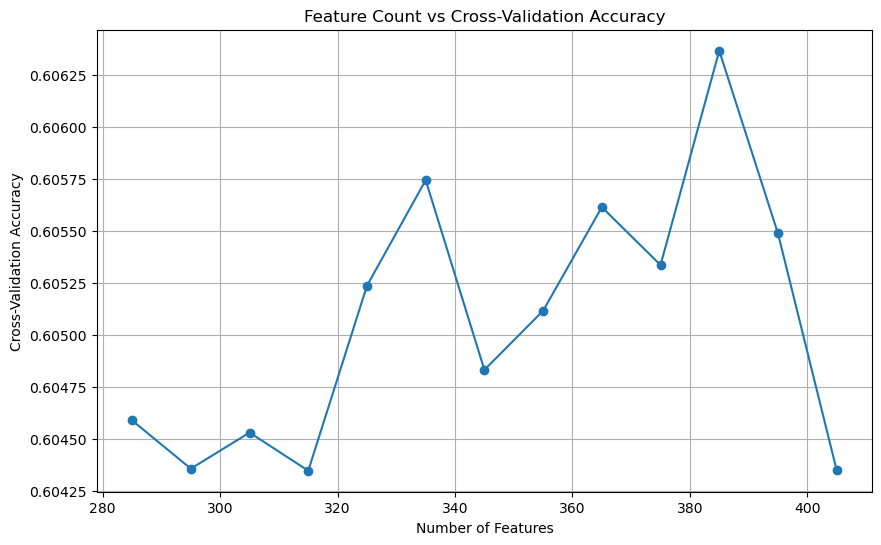

The best number of features within the range 285-405 is: 385 with an accuracy of: 0.6064


In [32]:
from sklearn.model_selection import cross_val_score

# Start from the number of features where you left off and continue to the new limit
# Since you mentioned the best number of features is between 285 and 300, you might want to start around there
start_feature_count = 285
end_feature_count = 405
feature_steps = 10  # To check each feature count between 285 and 300
cv_folds = 3

# Initialize the RandomForestClassifier
rf_classifier_quick = RandomForestClassifier(n_estimators=15, random_state=42)

cv_scores = []  # Initialize or continue with the previously calculated cv_scores

# Use incremental feature addition
for i in range(start_feature_count, end_feature_count + 1, feature_steps):
    # Select the top i features
    top_i_features = top_features[:i]
    X_train_top_i = X_train_top[top_i_features]
    
    # Perform cross-validation
    score = cross_val_score(rf_classifier_quick, X_train_top_i, y_train, cv=cv_folds, scoring='accuracy', n_jobs=-1).mean()
    cv_scores.append((i, score))

    print(f'Tested with top {i} features, cross-validation accuracy: {score:.4f}')

# Plot the cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(*zip(*cv_scores), marker='o')
plt.title('Feature Count vs Cross-Validation Accuracy')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validation Accuracy')
plt.grid(True)
plt.show()

# Find the number of features that gives the highest cross-validation score within the range tested
best_feature_count, best_score = max(cv_scores, key=lambda x: x[1])
print(f'The best number of features within the range {start_feature_count}-{end_feature_count} is: {best_feature_count} with an accuracy of: {best_score:.4f}')

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define your parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [10, 20, None],      # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required at each leaf node
    # You can include other parameters if needed
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,              # Number of folds in cross-validation
    n_jobs=-1,         # Use all available cores
    verbose=2          # Higher number means more print outs
)

# Fit the grid search to the data
# We'll time it to see how long it takes
import time
start_time = time.time()

grid_search.fit(X_train_top[top_features[:385]], y_train)  # Using the optimal number of features found

# Calculate elapsed time
elapsed_time = time.time() - start_time

# Print out the best parameters and the corresponding score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best parameters found: {best_params}")
print(f"Best cross-validation score: {best_score:.4f}")
print(f"Grid search took {elapsed_time // 60:.0f} minutes and {elapsed_time % 60:.0f} seconds.")

Fitting 3 folds for each of 81 candidates, totalling 243 fits


C:\Users\ckollwitz\anaconda3\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation score: 0.6377
Grid search took 293 minutes and 50 seconds.


In [35]:
from sklearn.metrics import accuracy_score

# Make predictions on the test set
y_pred_test = final_model.predict(X_test_top)

# Calculate the accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f'Test set accuracy: {test_accuracy:.4f}')

C:\Users\ckollwitz\anaconda3\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Test set accuracy: 0.6374


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   47.6s finished


Tested with top 1 features, cross-validation accuracy: 0.5329
Tested with top 6 features, cross-validation accuracy: 0.5858
Tested with top 11 features, cross-validation accuracy: 0.5897
Tested with top 16 features, cross-validation accuracy: 0.5918
Tested with top 21 features, cross-validation accuracy: 0.5901
Tested with top 26 features, cross-validation accuracy: 0.5929
Tested with top 31 features, cross-validation accuracy: 0.5977
Tested with top 36 features, cross-validation accuracy: 0.5984
Tested with top 41 features, cross-validation accuracy: 0.5985
Tested with top 46 features, cross-validation accuracy: 0.6006
Tested with top 51 features, cross-validation accuracy: 0.6019
Tested with top 56 features, cross-validation accuracy: 0.6031
Tested with top 61 features, cross-validation accuracy: 0.6054
Tested with top 66 features, cross-validation accuracy: 0.6063
Tested with top 71 features, cross-validation accuracy: 0.6092
Tested with top 76 features, cross-validation accuracy: 0

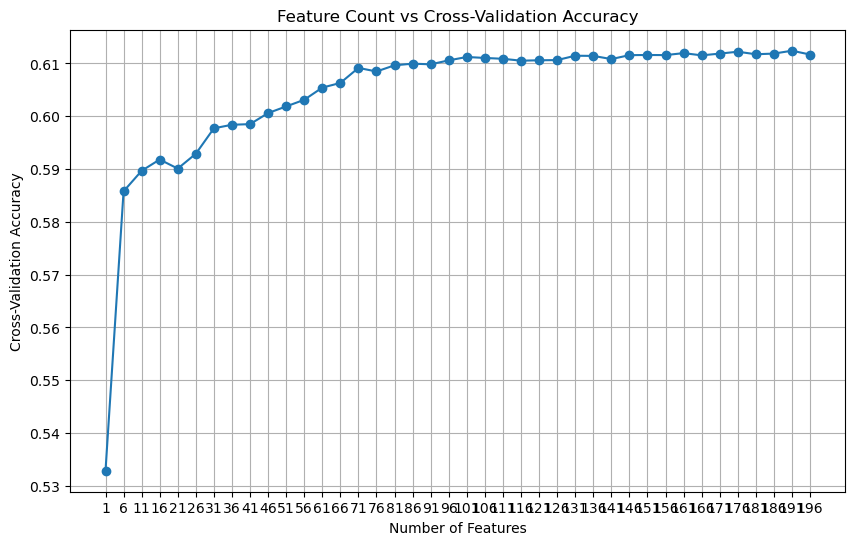

The optimal number of features is: 191 with an accuracy of: 0.6124


In [50]:
from sklearn.model_selection import cross_val_score

# Use a simpler model or reduce the number of estimators for quick evaluations
rf_classifier_quick = RandomForestClassifier(n_estimators=25, random_state=42)

# Adjust the number of cross-validation folds
cv_folds = 3

# Test every 5th feature count
feature_steps = 5

cv_scores = []

# Use incremental feature addition
for i in range(1, 201, feature_steps):
    top_i_features = top_100_features[:i]
    X_train_top_i = X_train[top_i_features]
    
    # Perform cross-validation with parallelization
    score = cross_val_score(rf_classifier_quick, X_train_top_i, y_train, cv=cv_folds, scoring='accuracy', n_jobs=-1).mean()
    cv_scores.append((i, score))

    print(f'Tested with top {i} features, cross-validation accuracy: {score:.4f}')

# Plot the cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(*zip(*cv_scores), marker='o')
plt.title('Feature Count vs Cross-Validation Accuracy')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validation Accuracy')
plt.xticks(range(1, 201, feature_steps))
plt.grid(True)
plt.show()

# Find the number of features that gives the highest cross-validation score
best_feature_count, best_score = max(cv_scores, key=lambda x: x[1])
print(f'The optimal number of features is: {best_feature_count} with an accuracy of: {best_score:.4f}')

Tested with top 200 features, cross-validation accuracy: 0.6126
Tested with top 205 features, cross-validation accuracy: 0.6127
Tested with top 210 features, cross-validation accuracy: 0.6125
Tested with top 215 features, cross-validation accuracy: 0.6125
Tested with top 220 features, cross-validation accuracy: 0.6125
Tested with top 225 features, cross-validation accuracy: 0.6121
Tested with top 230 features, cross-validation accuracy: 0.6131
Tested with top 235 features, cross-validation accuracy: 0.6126
Tested with top 240 features, cross-validation accuracy: 0.6137
Tested with top 245 features, cross-validation accuracy: 0.6128
Tested with top 250 features, cross-validation accuracy: 0.6126


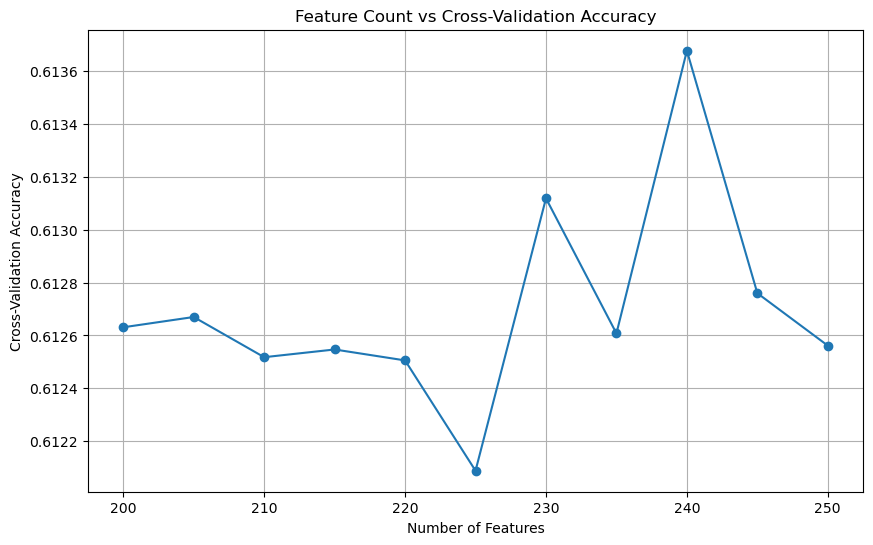

The best number of features within the range 200-250 is: 240 with an accuracy of: 0.6137


In [52]:
# Since we are using 25 trees, we will keep the RandomForestClassifier as is
rf_classifier_quick = RandomForestClassifier(n_estimators=25, random_state=42)

# Adjust the number of cross-validation folds if needed
cv_folds = 3

# Start from the number of features where you left off and continue to the new limit
start_feature_count = 200
end_feature_count = 250
feature_steps = 5

# Continue with the previously calculated cv_scores
# cv_scores = [...] (use your existing cv_scores list if you have it)

# Use incremental feature addition, starting from where you left off
for i in range(start_feature_count, end_feature_count + 1, feature_steps):
    top_i_features = top_100_features[:i]
    X_train_top_i = X_train[top_i_features]
    
    # Perform cross-validation with parallelization
    score = cross_val_score(rf_classifier_quick, X_train_top_i, y_train, cv=cv_folds, scoring='accuracy', n_jobs=-1).mean()
    cv_scores.append((i, score))

    print(f'Tested with top {i} features, cross-validation accuracy: {score:.4f}')

# You only need to plot the new range
plt.figure(figsize=(10, 6))
plt.plot(*zip(*cv_scores[-((end_feature_count - start_feature_count)//feature_steps + 1):]), marker='o')
plt.title('Feature Count vs Cross-Validation Accuracy')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validation Accuracy')
plt.grid(True)
plt.show()

# Find the number of features that gives the highest cross-validation score within the new range
best_feature_count, best_score = max(cv_scores[-((end_feature_count - start_feature_count)//feature_steps + 1):], key=lambda x: x[1])
print(f'The best number of features within the range {start_feature_count}-{end_feature_count} is: {best_feature_count} with an accuracy of: {best_score:.4f}')

Tested with top 250 features, cross-validation accuracy: 0.6126
Tested with top 255 features, cross-validation accuracy: 0.6125
Tested with top 260 features, cross-validation accuracy: 0.6126
Tested with top 265 features, cross-validation accuracy: 0.6133
Tested with top 270 features, cross-validation accuracy: 0.6132
Tested with top 275 features, cross-validation accuracy: 0.6139
Tested with top 280 features, cross-validation accuracy: 0.6125
Tested with top 285 features, cross-validation accuracy: 0.6140
Tested with top 290 features, cross-validation accuracy: 0.6130
Tested with top 295 features, cross-validation accuracy: 0.6135
Tested with top 300 features, cross-validation accuracy: 0.6132


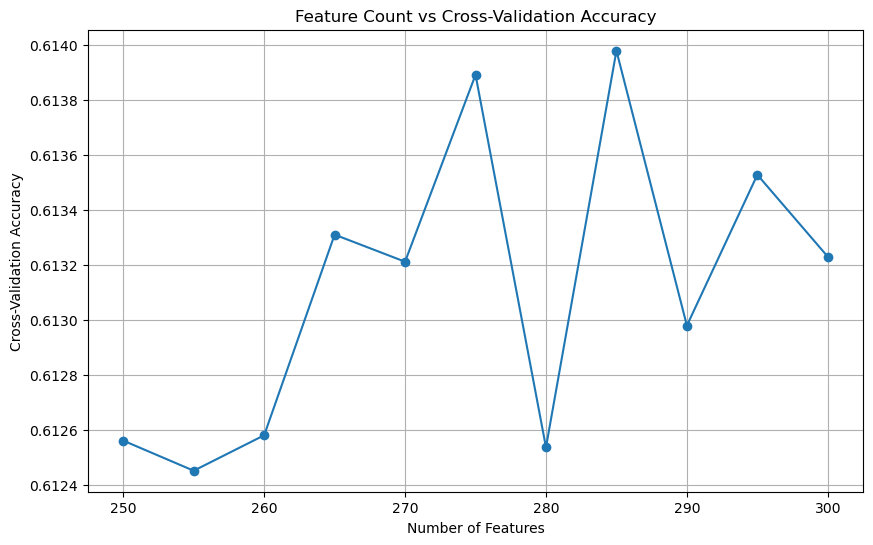

The best number of features within the range 250-300 is: 285 with an accuracy of: 0.6140


In [54]:
# Since we are using 25 trees, we will keep the RandomForestClassifier as is
rf_classifier_quick = RandomForestClassifier(n_estimators=25, random_state=42)

# Adjust the number of cross-validation folds if needed
cv_folds = 3

# Start from the number of features where you left off and continue to the new limit
start_feature_count = 250
end_feature_count = 300
feature_steps = 5

# Continue with the previously calculated cv_scores
# cv_scores = [...] (use your existing cv_scores list if you have it)

# Use incremental feature addition, starting from where you left off
for i in range(start_feature_count, end_feature_count + 1, feature_steps):
    top_i_features = top_100_features[:i]
    X_train_top_i = X_train[top_i_features]
    
    # Perform cross-validation with parallelization
    score = cross_val_score(rf_classifier_quick, X_train_top_i, y_train, cv=cv_folds, scoring='accuracy', n_jobs=-1).mean()
    cv_scores.append((i, score))

    print(f'Tested with top {i} features, cross-validation accuracy: {score:.4f}')

# You only need to plot the new range
plt.figure(figsize=(10, 6))
plt.plot(*zip(*cv_scores[-((end_feature_count - start_feature_count)//feature_steps + 1):]), marker='o')
plt.title('Feature Count vs Cross-Validation Accuracy')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validation Accuracy')
plt.grid(True)
plt.show()

# Find the number of features that gives the highest cross-validation score within the new range
best_feature_count, best_score = max(cv_scores[-((end_feature_count - start_feature_count)//feature_steps + 1):], key=lambda x: x[1])
print(f'The best number of features within the range {start_feature_count}-{end_feature_count} is: {best_feature_count} with an accuracy of: {best_score:.4f}')

Tested with top 300 features, cross-validation accuracy: 0.6132
Tested with top 305 features, cross-validation accuracy: 0.6135
Tested with top 310 features, cross-validation accuracy: 0.6133
Tested with top 315 features, cross-validation accuracy: 0.6130
Tested with top 320 features, cross-validation accuracy: 0.6135
Tested with top 325 features, cross-validation accuracy: 0.6134


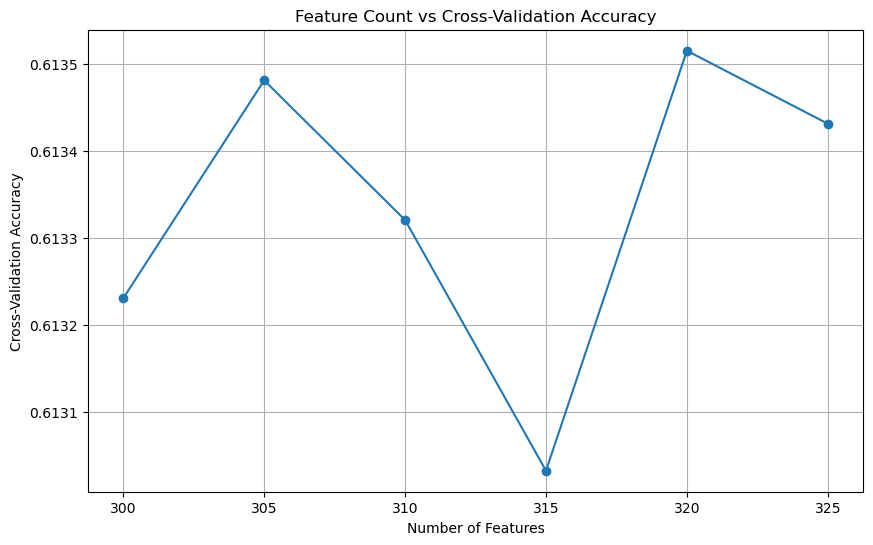

The best number of features within the range 300-325 is: 320 with an accuracy of: 0.6135


In [56]:
# Since we are using 25 trees, we will keep the RandomForestClassifier as is
rf_classifier_quick = RandomForestClassifier(n_estimators=25, random_state=42)

# Adjust the number of cross-validation folds if needed
cv_folds = 3

# Start from the number of features where you left off and continue to the new limit
start_feature_count = 300
end_feature_count = 325
feature_steps = 5

# Continue with the previously calculated cv_scores
# cv_scores = [...] (use your existing cv_scores list if you have it)

# Use incremental feature addition, starting from where you left off
for i in range(start_feature_count, end_feature_count + 1, feature_steps):
    top_i_features = top_100_features[:i]
    X_train_top_i = X_train[top_i_features]
    
    # Perform cross-validation with parallelization
    score = cross_val_score(rf_classifier_quick, X_train_top_i, y_train, cv=cv_folds, scoring='accuracy', n_jobs=-1).mean()
    cv_scores.append((i, score))

    print(f'Tested with top {i} features, cross-validation accuracy: {score:.4f}')

# You only need to plot the new range
plt.figure(figsize=(10, 6))
plt.plot(*zip(*cv_scores[-((end_feature_count - start_feature_count)//feature_steps + 1):]), marker='o')
plt.title('Feature Count vs Cross-Validation Accuracy')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validation Accuracy')
plt.grid(True)
plt.show()

# Find the number of features that gives the highest cross-validation score within the new range
best_feature_count, best_score = max(cv_scores[-((end_feature_count - start_feature_count)//feature_steps + 1):], key=lambda x: x[1])
print(f'The best number of features within the range {start_feature_count}-{end_feature_count} is: {best_feature_count} with an accuracy of: {best_score:.4f}')

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming you have already split your data into training and testing sets
# and top_100_features is a list of your feature names

# Train the RandomForest model with 100 trees and selected features
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train[top_100_features[:300]], y_train)

# Evaluate on the test set
y_pred = rf_classifier.predict(X_test[top_100_features[:300]])
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy with selected features and 100 trees: {accuracy:.4f}')


C:\Users\ckollwitz\anaconda3\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\ckollwitz\anaconda3\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Accuracy with selected features and 100 trees: 0.6270


## Hyperparameter Finetuning

**Model Inititation**

In [ ]:
random_forest = RandomForestClassifier(random_state=42)

**parameter optimization with subset of data**

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Assuming X and y are already defined

# Take a 30% subset of the data for faster computation
subset_size = int(len(X) * 0.3)  # 30% of the data
subset_indices = np.random.choice(range(len(X)), size=subset_size, replace=False)
X_subset = X.iloc[subset_indices]
y_subset = y.iloc[subset_indices]

# Split the subset into training and testing sets
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
    X_subset, y_subset, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a RandomForestClassifier object
random_forest = RandomForestClassifier(random_state=42)

# Random search of parameters using the subset
random_search = RandomizedSearchCV(estimator=random_forest, param_distributions=param_grid, 
                                   n_iter=30, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model on the subset
random_search.fit(X_train_sub, y_train_sub)

In [35]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    'bootstrap': [True, False]
}

# Random search of parameters
random_search = RandomizedSearchCV(estimator=random_forest, param_distributions=param_grid, n_iter=30, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
random_search.fit(X_train, y_train)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\lweil\.conda\envs\FNN\lib\site-packages\sklearn\utils\validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=42, verbose=2)

In [36]:
# Retrieve the best hyperparameters
best_params = random_search.best_params_
print("Best hyperparameters:", best_params)

# Retrieve the best score
best_score = random_search.best_score_
print("Best score (accuracy):", best_score)

# Retrieve the best estimator (model)
best_model = random_search.best_estimator_

Best hyperparameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20}
Best score (accuracy): 0.6310826120361116


**More granular hyperparameter optimization with all the data**

In [ ]:
param_grid_fine = {
    'n_estimators': [280, 290, 300, 310, 320],
    'max_depth': [18, 19, 20, 21, 22],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['auto', 'sqrt', 191, 240, 285, 320, 385]  # Including specific feature numbers
}

random_search_fine = RandomizedSearchCV(
    estimator=random_forest, 
    param_distributions=param_grid_fine, 
    n_iter=20,  # Reduced iterations for focused search
    cv=3, 
    verbose=2, 
    random_state=42, 
    n_jobs=-1
)

# Fit the random search model
random_search_fine.fit(X_train, y_train)

# Best hyperparameters and score
best_params_fine = random_search_fine.best_params_
best_score_fine = random_search_fine.best_score_
print("Best hyperparameters:", best_params_fine)
print("Best score (accuracy):", best_score_fine)




Fitting 3 folds for each of 20 candidates, totalling 60 fits


**Results for this extensive hyperparameter optimization (due to resource constraints this was done in another notebook)**:

{'n_estimators': 320,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_features': 191,
 'max_depth': 22}

## Model Training and Evaluation

C:\Users\lweil\.conda\envs\FNN\lib\site-packages\sklearn\utils\validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\lweil\.conda\envs\FNN\lib\site-packages\sklearn\utils\validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\lweil\.conda\envs\FNN\lib\site-packages\sklearn\utils\validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


Training Subset Accuracy: 0.7181922178230674
Test Accuracy: 0.6350187657902807


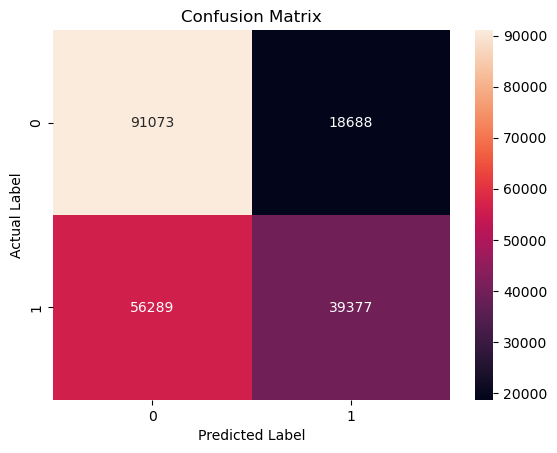

C:\Users\lweil\.conda\envs\FNN\lib\site-packages\sklearn\utils\validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


AUC-ROC Score: 0.6641901894527686


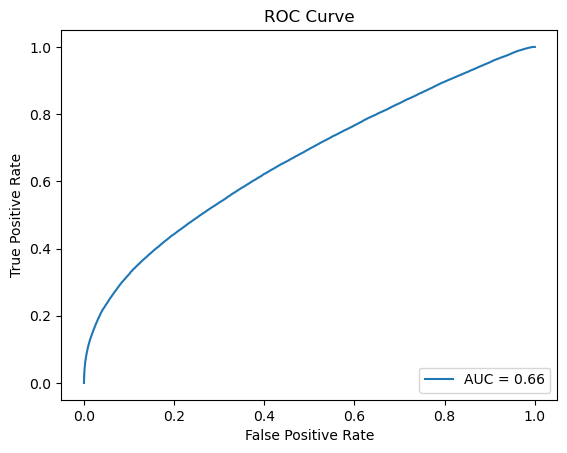

In [67]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming X_train and y_train are already defined

# Create a smaller subset of 30% of the training data
subset_indices = np.random.choice(X_train.shape[0], size=int(X_train.shape[0] * 0.3), replace=False)
X_train_subset = X_train.iloc[subset_indices]
y_train_subset = y_train.iloc[subset_indices]

# Considering the top 385 most important features (assuming 'indices' is already defined)
top_features = X_train.columns[indices[:385]]
X_train_subset_top = X_train_subset[top_features]
X_test_top = X_test[top_features]

# Create a RandomForest Classifier with the best parameters
rf_best = RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_leaf=4, min_samples_split=2, random_state=42)

# Fit the model on the subset of training data
rf_best.fit(X_train_subset_top, y_train_subset)

# Predict on the subset of training data and the full test set
y_train_subset_pred = rf_best.predict(X_train_subset_top)
y_test_pred = rf_best.predict(X_test_top)

# Calculate and print the accuracy on the subset of training data and the test set
train_subset_accuracy = accuracy_score(y_train_subset, y_train_subset_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Training Subset Accuracy: {train_subset_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Confusion Matrix for the test set
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# AUC-ROC scores and plot
y_test_prob = rf_best.predict_proba(X_test_top)[:, 1]
auc_roc = roc_auc_score(y_test, y_test_prob)
print(f"AUC-ROC Score: {auc_roc}")

fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.plot(fpr, tpr, label=f'AUC = {auc_roc:.2f}')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


## Model Training and Evaluation with all data

C:\Users\lweil\.conda\envs\FNN\lib\site-packages\sklearn\utils\validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\lweil\.conda\envs\FNN\lib\site-packages\sklearn\utils\validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\lweil\.conda\envs\FNN\lib\site-packages\sklearn\utils\validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


Training Accuracy: 0.6466879313429239
Test Accuracy: 0.6327892633392884


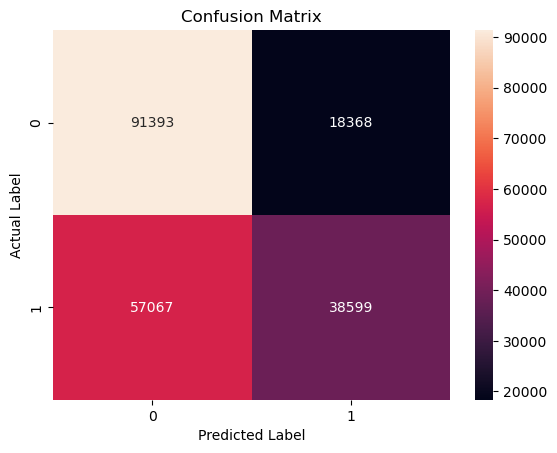

C:\Users\lweil\.conda\envs\FNN\lib\site-packages\sklearn\utils\validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


AUC-ROC Score: 0.6647112066211361


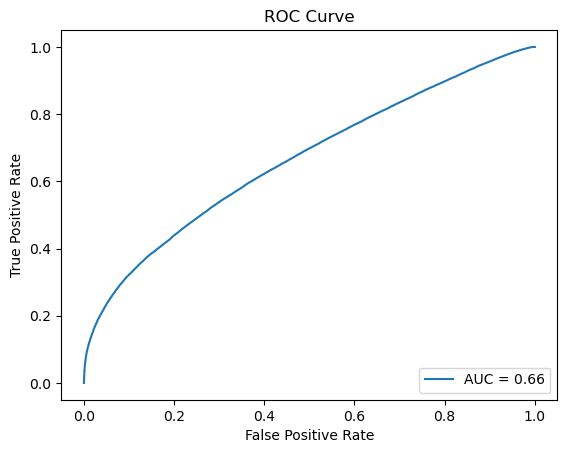

In [140]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_train, X_test, y_train, y_test are already defined and
# the 'indices' of the top features are determined from your initial Random Forest model

# Selecting the top 385 features
top_features = X_train.columns[indices[:385]]

# Subsetting the train and test sets to include only the top 385 features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Create a RandomForest Classifier with the best parameters
rf_best = RandomForestClassifier(n_estimators=320, max_depth=22, min_samples_leaf=1, min_samples_split=6, random_state=42)

# Fit the model on the training set with top 385 features
rf_best.fit(X_train_top, y_train)

# Predict on the training and test sets
y_train_pred = rf_best.predict(X_train_top)
y_test_pred = rf_best.predict(X_test_top)

# Calculate and print the accuracy on the train and test set
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Confusion Matrix for the test set
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# AUC-ROC scores
y_test_prob = rf_best.predict_proba(X_test_top)[:, 1]
auc_roc = roc_auc_score(y_test, y_test_prob)
print(f"AUC-ROC Score: {auc_roc}")

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.plot(fpr, tpr, label=f'AUC = {auc_roc:.2f}')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


## Model Evaluation with 2015 data

C:\Users\lweil\.conda\envs\FNN\lib\site-packages\sklearn\utils\validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


Accuracy on 2015 Data: 0.6319486360715746


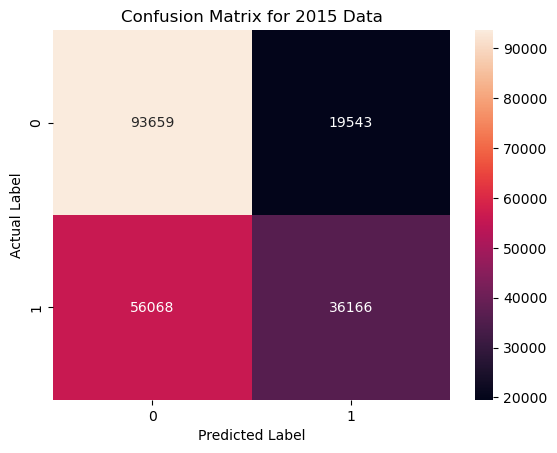

In [141]:
# Filter df2015 to include only the top 385 features
X_2015 = df2015[top_features]

# Extract the labels
y_2015 = df2015['SHOT_MADE']

# Predict on the 2015 dataset
y_2015_pred = rf_best.predict(X_2015)

# Calculate and print the accuracy
accuracy_2015 = accuracy_score(y_2015, y_2015_pred)
print(f"Accuracy on 2015 Data: {accuracy_2015}")

# Confusion Matrix
conf_matrix_2015 = confusion_matrix(y_2015, y_2015_pred)
sns.heatmap(conf_matrix_2015, annot=True, fmt='g')
plt.title('Confusion Matrix for 2015 Data')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

C:\Users\lweil\.conda\envs\FNN\lib\site-packages\sklearn\utils\validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


ROC-AUC Score for 2015 Data: 0.6657930208482855


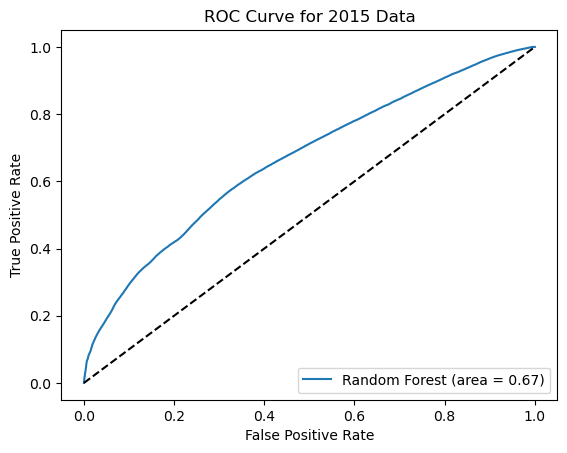

In [142]:
y_2015_pred_proba = rf_best.predict_proba(X_2015)[:, 1]  # Probabilities for the positive class

# ROC-AUC Score
roc_auc_2015 = roc_auc_score(y_2015, y_2015_pred_proba)
print(f"ROC-AUC Score for 2015 Data: {roc_auc_2015}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_2015, y_2015_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % roc_auc_2015)
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for 2015 Data')
plt.legend(loc="lower right")
plt.show()